<a href="https://colab.research.google.com/github/everson-rodrigues/Bayesian-Analysis/blob/main/Bayesian_model_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Bayesian Model Selection

Bayesian model selection provides a principled framework for comparing different models using probability theory. Instead of relying solely on goodness-of-fit, Bayesian methods incorporate prior information and quantify the evidence for each model given the observed data.

A key quantity in Bayesian model selection is the **Bayes factor**, which compares the relative probabilities of two competing models, $M_1$ and $M_2$, given the data $D$:

$$
\text{Bayes Factor} = \frac{p(D \mid M_1)}{p(D \mid M_2)}
$$

Here, $p(D \mid M)$ is the **marginal likelihood** or **evidence** for model $M$, obtained by integrating the likelihood over all possible parameter values weighted by their prior probabilities. The Bayes factor quantifies how much more likely the data are under one model compared to another. Values greater than one favor $M_1$, while values less than one favor $M_2$.

Bayesian model selection naturally penalizes model complexity, helping to avoid overfitting and guiding the choice of the most plausible model given the data.

In practice, we often work with the logarithm of the Bayes factor for numerical stability:

$$
\ln \text{Bayes Factor} = \ln p(D \mid M_1) - \ln p(D \mid M_2)
$$

Here, $\ln p(D \mid M)$ is the log-evidence (sometimes called the log marginal likelihood) for model $M$. A positive value favors $M_1$, while a negative value favors $M_2$.

In this context, we assume equal prior probabilities for the models, so the Bayes factor directly reflects the relative support from the data alone.


In [3]:
!pip install dynesty

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.2/108.2 kB 1.5 MB/s eta 0:00:00


In [4]:
import numpy as np
from matplotlib import pyplot as plt
from dynesty import NestedSampler           # sampler
import dynesty.plotting as dyplot           # plotting tools
from dynesty import utils as dyfunc         # useful functions

In [5]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 30})

Reading the data and plotting it.



In [ ]:
x, yobs, yerr = np.loadtxt('model_selection_data.txt', unpack=True)

plt.figure(figsize=(10, 6))
plt.scatter(x, yobs, label='Data', color='b')
plt.errorbar(x, yobs, yerr=yerr, fmt='o', color='b', capsize=5)

plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()


Let's define three different models that can reproduce the data:

- Two polynomial models, of order 3 and 5.
- One trigonometric model.

The models are defined as follows:

- **Cubic Polynomial (Order 3):**
    $$
    y = a + b x + c x^2 + d x^3
    $$

- **Quintic Polynomial (Order 5):**
    $$
    y = a + b x + c x^2 + d x^3 + e x^4 + f x^5
    $$

- **Trigonometric Model:**
    $$
    y = a \sin(b x) + c
    $$

Note that a polynomial of order 2 would not be able to reproduce the dataset, as it changes concavity only once. Higher-order polynomials or trigonometric functions are needed to capture the complexity of the data.

In [ ]:
def model_poly3(a, b, c, d, x):
    """
    Cubic polynomial model: y = a + b*x + c*x^2 + d*x^3

    Parameters:
    ----------
    a, b, c, d : coefficients of the polynomial
    x : independent variable (numpy array)
    Returns:
    -------
    y : dependent variable (numpy array) assuming a 3rd order polynomial model
    """
    return a + b * x + c * x**2 + d * x**3

def model_poly5(a, b, c, d, e, f, x):
    """
    Quintic polynomial model: y = a + b*x + c*x^2 + d*x^3 + e*x^4 + f*x^5

    Parameters:
    ----------
    a, b, c, d, e, f : coefficients of the polynomial
    x : independent variable (numpy array)
    Returns:
    -------
    y : dependent variable (numpy array) assuming a 5th order polynomial model
    """
    return a + b * x + c * x**2 + d * x**3 + e * x**4 + f * x**5

def model_trig(a, b, c, x):
    """
    Trigonometric model: y = a * np.sin(b * x) + c
    Parameters:
    ----------
    a, b, c : coefficients of the model
    x : independent variable (numpy array)
    Returns:
    -------
    y : dependent variable (numpy array) assuming a trigonometric model
    """
    return a * np.sin(b * x) + c

For each model, we will define the log-likelihood and prior transform functions required by `dynesty`.

Assuming Gaussian noise, the likelihood is well described by a chi-square function.

In [ ]:
def log_likelihood_poly3(theta, x=x, yobs=yobs, yerr=yerr):
    """
    Log-likelihood function for the cubic polynomial model.

    Parameters:
    ----------
    theta : array-like, shape (4,)
        Model parameters [a, b, c, d]
    x : independent variable (numpy array)
    yobs : observed data (numpy array)
    yerr : measurement uncertainties (numpy array)

    Returns:
    -------
    logL : float
        Log-likelihood value
    """
    a, b, c, d = theta
    y_model = model_poly3(a, b, c, d, x)
    logL = -0.5 * np.sum(( (yobs - y_model) / yerr) ** 2 + np.log(2 * np.pi * yerr**2))
    return logL

def log_likelihood_poly5(theta, x=x, yobs=yobs, yerr=yerr):
    """
    Log-likelihood function for the quintic polynomial model.

    Parameters:
    ----------
    theta : array-like, shape (6,)
        Model parameters [a, b, c, d, e, f]
    x : independent variable (numpy array)
    yobs : observed data (numpy array)
    yerr : measurement uncertainties (numpy array)

    Returns:
    -------
    logL : float
        Log-likelihood value
    """
    a, b, c, d, e, f = theta
    y_model = model_poly5(a, b, c, d, e, f, x)
    logL = -0.5 * np.sum(( (yobs - y_model) / yerr) ** 2 + np.log(2 * np.pi * yerr**2))
    return logL

def log_likelihood_trig(theta, x=x, yobs=yobs, yerr=yerr):
    """
    Log-likelihood function for the trigonometric model.

    Parameters:
    ----------
    theta : array-like, shape (3,)
        Model parameters [a, b, c]
    x : independent variable (numpy array)
    yobs : observed data (numpy array)
    yerr : measurement uncertainties (numpy array)

    Returns:
    -------
    logL : float
        Log-likelihood value
    """
    a, b, c = theta
    y_model = model_trig(a, b, c, x)
    logL = -0.5 * np.sum(( (yobs - y_model) / yerr) ** 2 + np.log(2 * np.pi * yerr**2))
    return logL

In [ ]:
parameters_poly3 = ['a', 'b', 'c', 'd']
n_params_poly3 = len(parameters_poly3)

parameters_poly5 = ['a', 'b', 'c', 'd', 'e', 'f']
n_params_poly5 = len(parameters_poly5)

parameters_trig = ['a', 'b', 'c']
n_params_trig = len(parameters_trig)

def prior_transform_poly3(ucube):
    """
    Prior transform function for the cubic polynomial model.

    Parameters:
    ----------
    ucube : array-like, shape (4,)
        Unit cube parameters in [0, 1]

    Returns:
    -------
    theta : array-like, shape (4,)
        Transformed parameters [a, b, c, d] in their respective prior ranges
    """
    a = -10 + 20 * ucube[0]   # Uniform prior for a in [-10, 10]
    b = -10 + 20 * ucube[1]   # Uniform prior for b in [-10, 10]
    c = -10 + 20 * ucube[2]   # Uniform prior for c in [-10, 10]
    d = -10 + 20 * ucube[3]   # Uniform prior for d in [-10, 10]
    return np.array([a, b, c, d])

def prior_transform_poly5(ucube):
    """
    Prior transform function for the quintic polynomial model.

    Parameters:
    ----------
    ucube : array-like, shape (6,)
        Unit cube parameters in [0, 1]

    Returns:
    -------
    theta : array-like, shape (6,)
        Transformed parameters [a, b, c, d, e, f] in their respective prior ranges
    """
    a = -10 + 20 * ucube[0]   # Uniform prior for a in [-10, 10]
    b = -10 + 20 * ucube[1]   # Uniform prior for b in [-10, 10]
    c = -10 + 20 * ucube[2]   # Uniform prior for c in [-10, 10]
    d = -10 + 20 * ucube[3]   # Uniform prior for d in [-10, 10]
    e = -10 + 20 * ucube[4]   # Uniform prior for e in [-10, 10]
    f = -10 + 20 * ucube[5]   # Uniform prior for f in [-10, 10]
    return np.array([a, b, c, d, e, f])

def prior_transform_trig(ucube):
    """
    Prior transform function for the trigonometric model.

    Parameters:
    ----------
    ucube : array-like, shape (3,)
        Unit cube parameters in [0, 1]

    Returns:
    -------
    theta : array-like, shape (3,)
        Transformed parameters [a, b, c] in their respective prior ranges
    """
    a = -10 + 20 * ucube[0]   # Uniform prior for a in [-10, 10]
    b = -10 + 20 * ucube[1]   # Uniform prior for b in [-10, 10]
    c = -10 + 20 * ucube[2]   # Uniform prior for c in [-10, 10]
    return np.array([a, b, c])

Because now we have many models, would be good to speed up the sampling. One way is to use multiprocessing.
`dynesty` supports this natively and offers a simple way to do it.

In [ ]:
import dynesty.pool as dypool       # for parallelization


# Poly3 model
with dypool.Pool(njobs=8,
                    loglike=log_likelihood_poly3,
                    logl_args=(x, yobs, yerr),
                    prior_transform=prior_transform_poly3) as pool:
    sampler_poly3 = NestedSampler(pool.loglike, pool.prior_transform, n_params_poly3,
                                  nlive=500, bound='multi', sample='rwalk', pool=pool)
    sampler_poly3.run_nested(dlogz=0.1)
    results_poly3 = sampler_poly3.results
    print("Poly3 model finished!")

# Poly5 model
with dypool.Pool(njobs=8,
                    loglike=log_likelihood_poly5,
                    logl_args=(x, yobs, yerr),
                    prior_transform=prior_transform_poly5) as pool:
    sampler_poly5 = NestedSampler(pool.loglike, pool.prior_transform, n_params_poly5,
                                  nlive=500, bound='multi', sample='rwalk', pool=pool)
    sampler_poly5.run_nested(dlogz=0.1)
    results_poly5 = sampler_poly5.results
    print("Poly5 model finished!")

# Trig model
with dypool.Pool(njobs=8,
                    loglike=log_likelihood_trig,
                    logl_args=(x, yobs, yerr),
                    prior_transform=prior_transform_trig) as pool:
    sampler_trig = NestedSampler(pool.loglike, pool.prior_transform, n_params_trig,
                                  nlive=500, bound='multi', sample='rwalk', pool=pool)
    sampler_trig.run_nested(dlogz=0.1)
    results_trig = sampler_trig.results
    print("Trig model finished!")


13117it [00:21, 599.73it/s, +500 | bound: 142 | nc: 1 | ncall: 291216 | eff(%):  4.684 | loglstar:   -inf < -80.094 <    inf | logz: -103.970 +/-  0.211 | dlogz:  0.000 >  0.100]  

Poly3 model finished!



21651it [00:32, 659.21it/s, +500 | bound: 250 | nc: 1 | ncall: 538122 | eff(%):  4.120 | loglstar:   -inf < -52.091 <    inf | logz: -93.035 +/-  0.278 | dlogz:  0.000 >  0.100]    


Poly5 model finished!


8169it [00:15, 529.22it/s, +500 | bound: 80 | nc: 1 | ncall: 164867 | eff(%):  5.274 | loglstar:   -inf < -64.081 <    inf | logz: -78.063 +/-  0.159 | dlogz:  0.000 >  0.100]

Trig model finished!


Let's check the summary of results for each model.

In [ ]:
results_poly3.summary()
results_poly5.summary()
results_trig.summary()

Summary
nlive: 500
niter: 13117
ncall: 290716
eff(%):  4.684
logz: -103.970 +/-  0.257
Summary
nlive: 500
niter: 21651
ncall: 537622
eff(%):  4.120
logz: -93.035 +/-  0.333
Summary
nlive: 500
niter: 8169
ncall: 164367
eff(%):  5.274
logz: -78.063 +/-  0.196


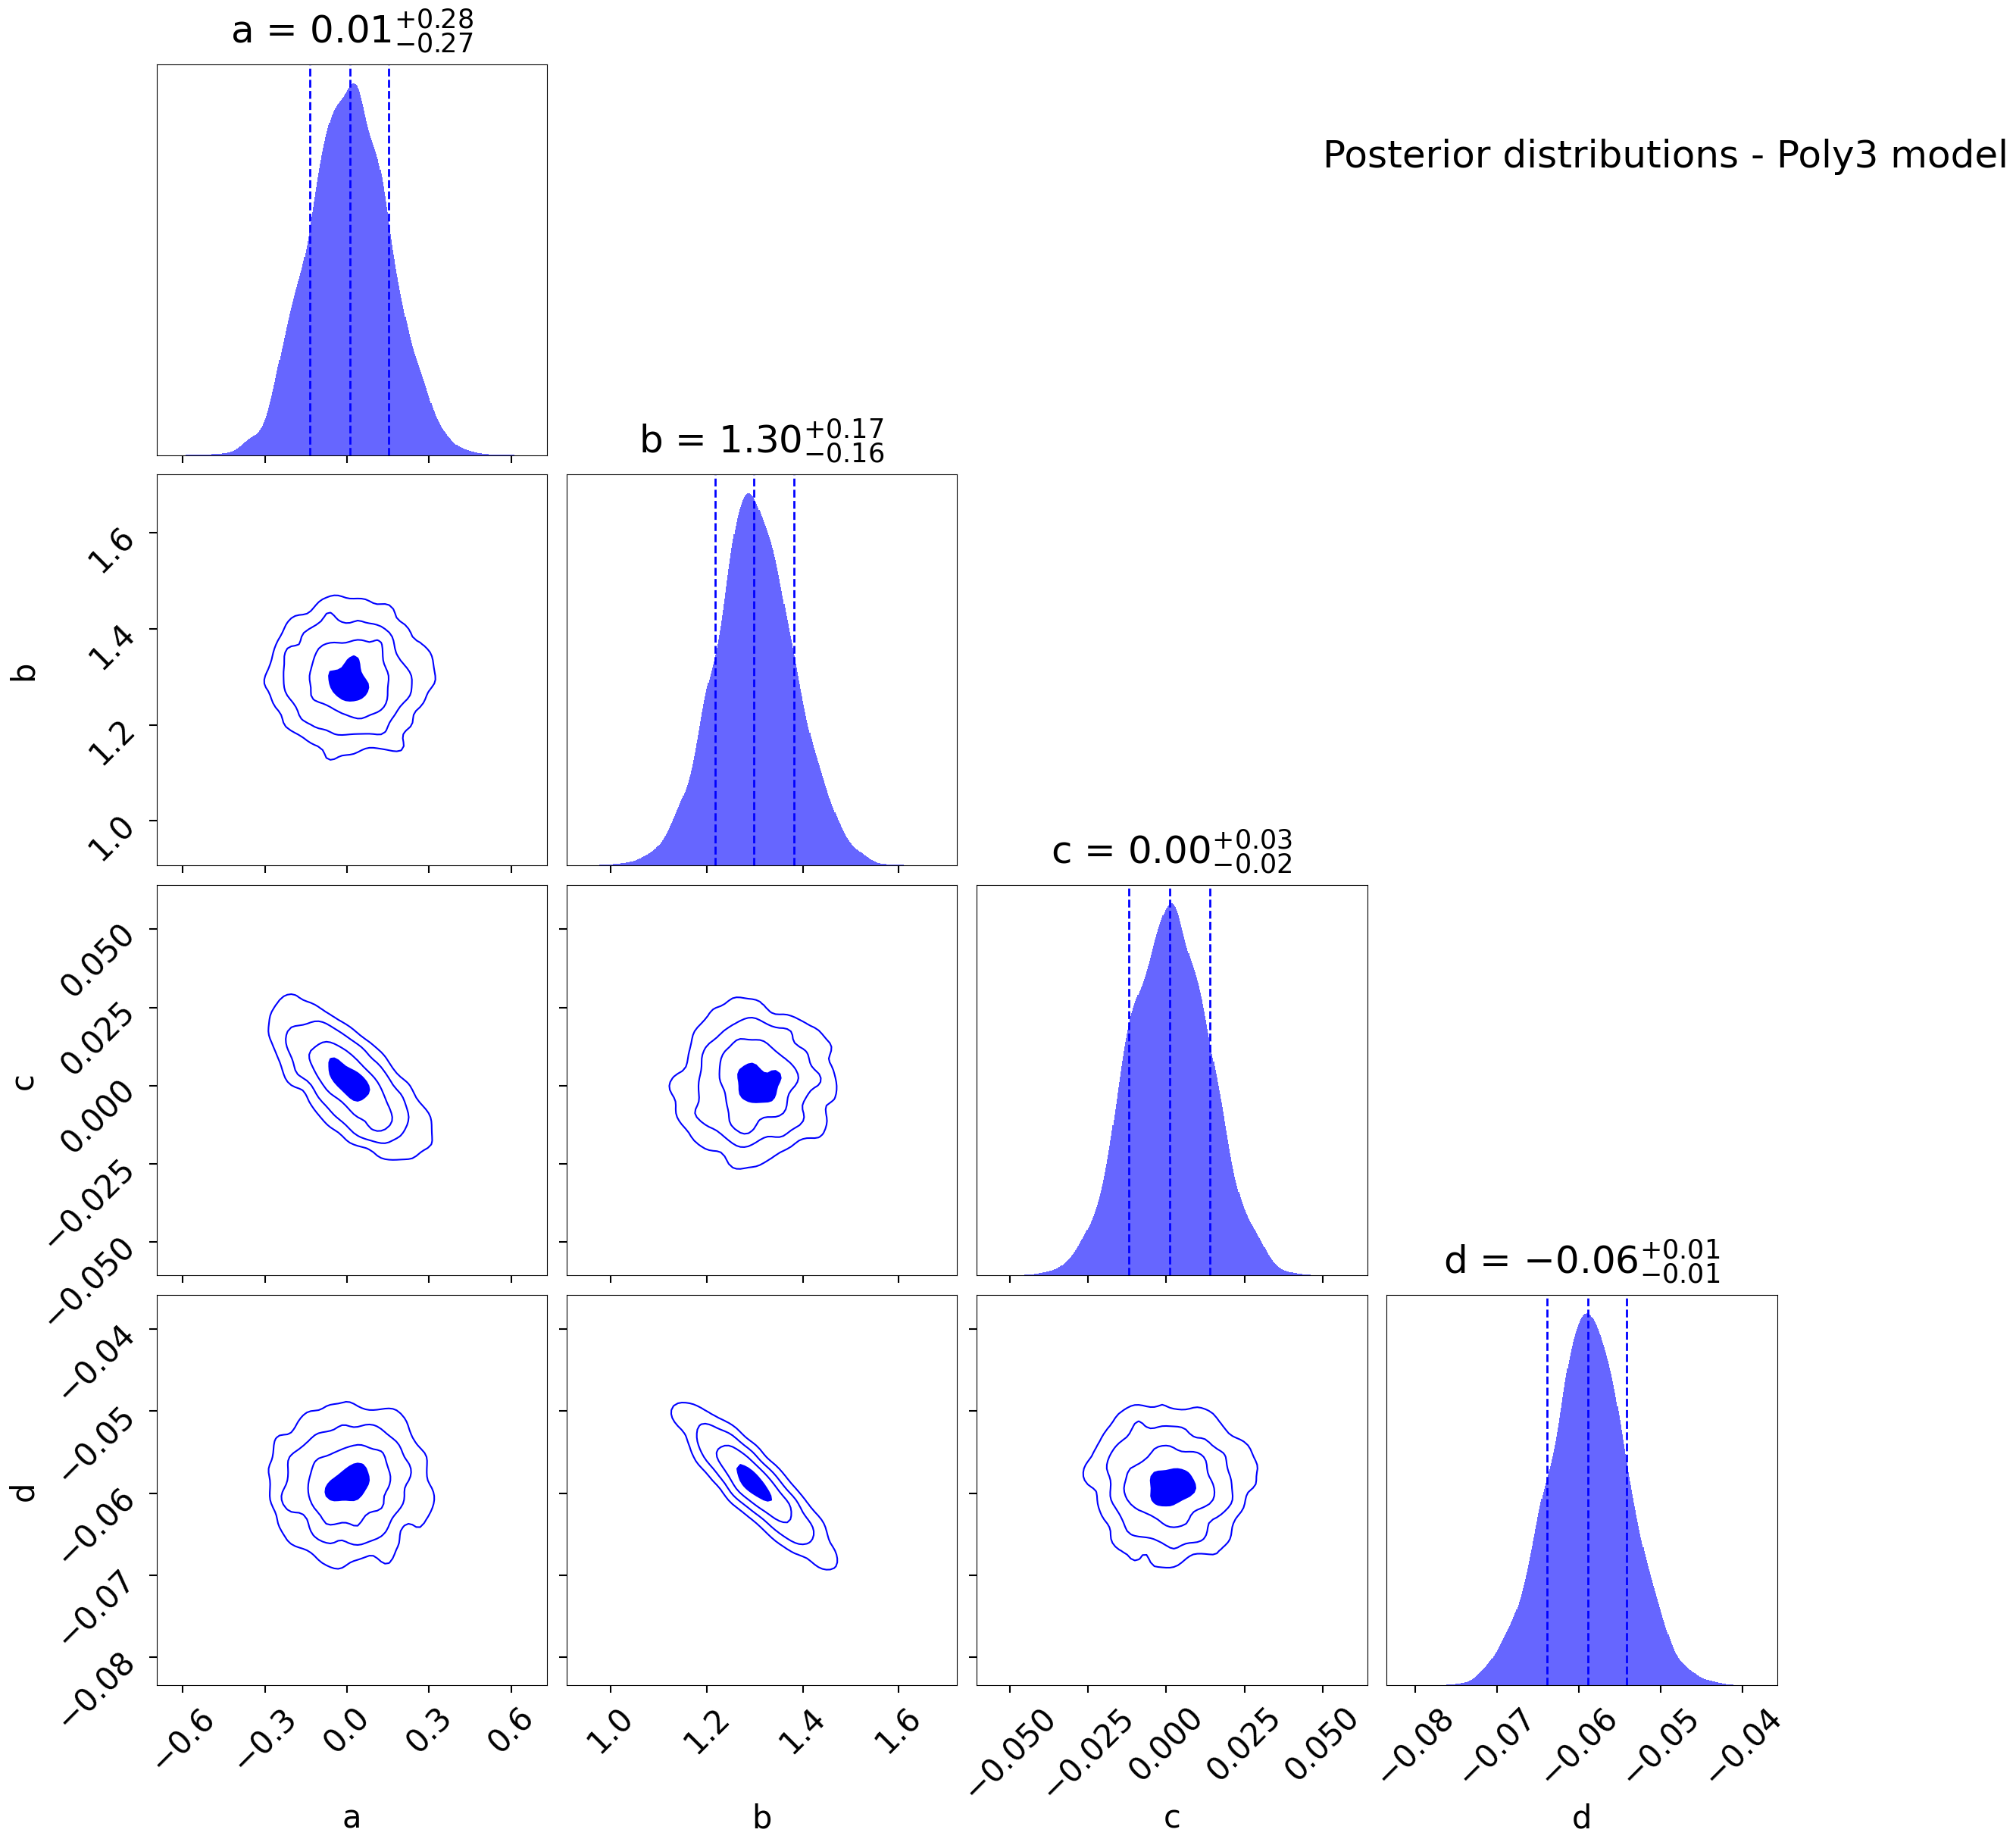

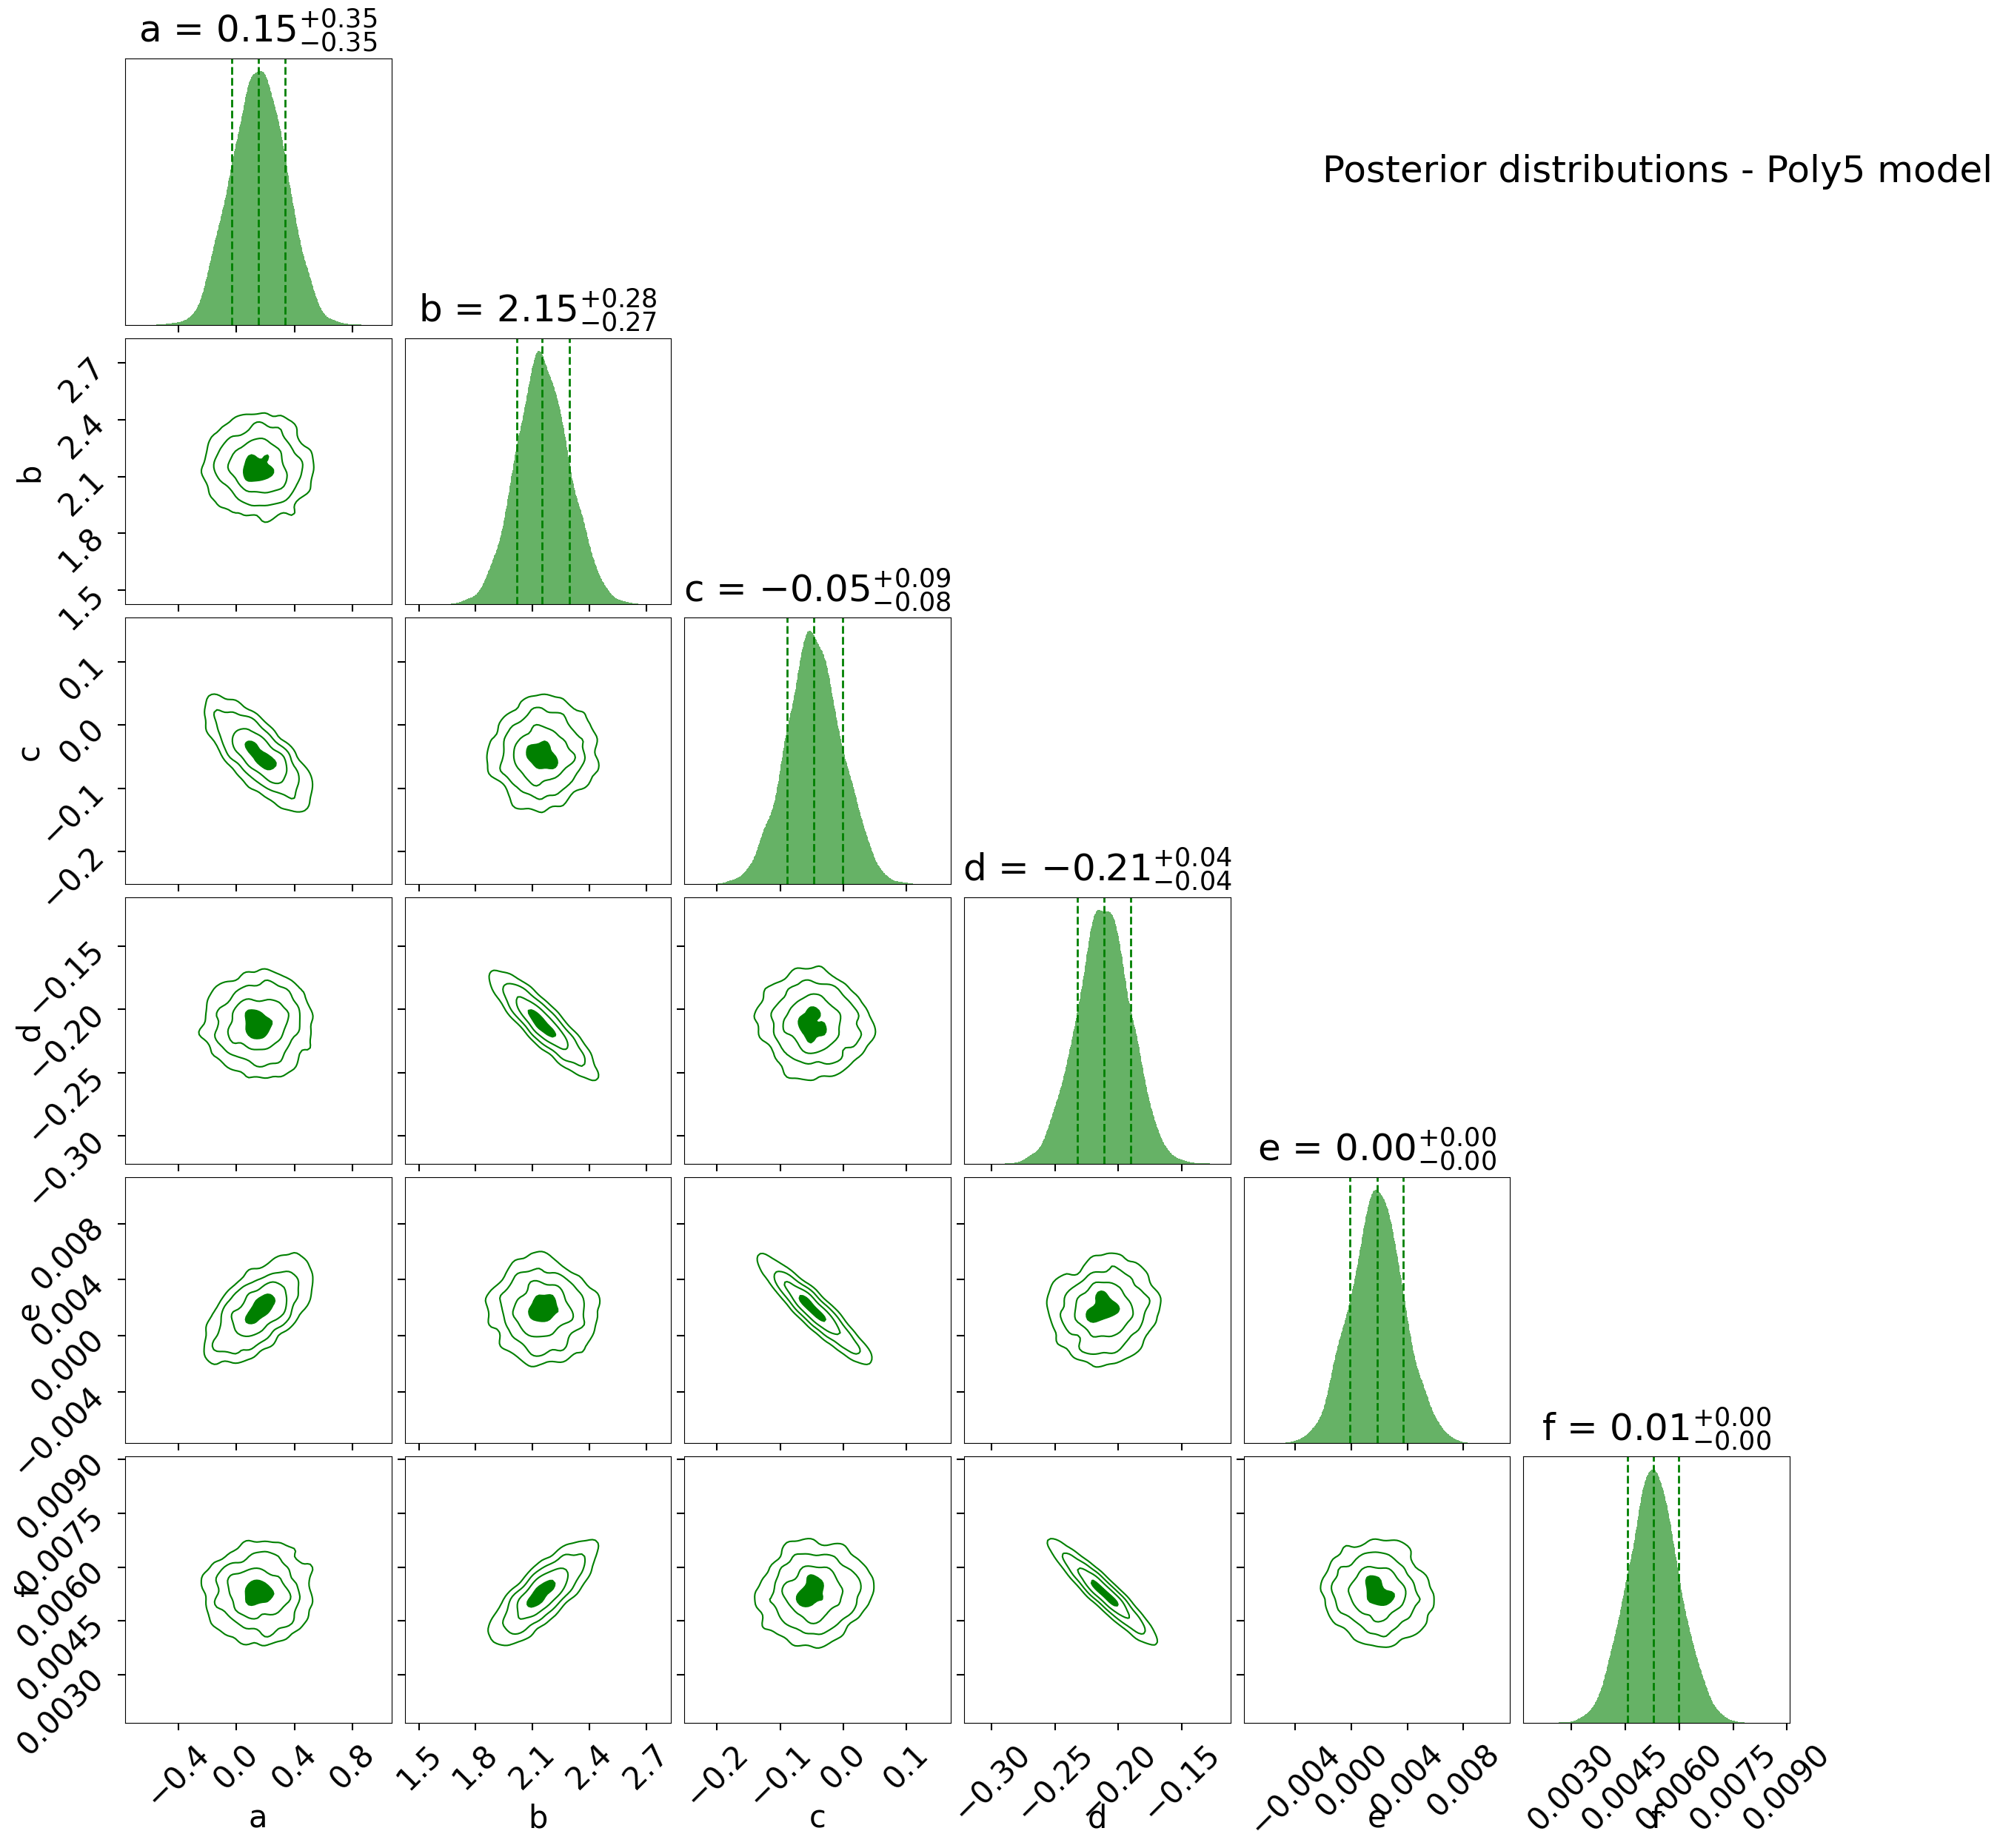

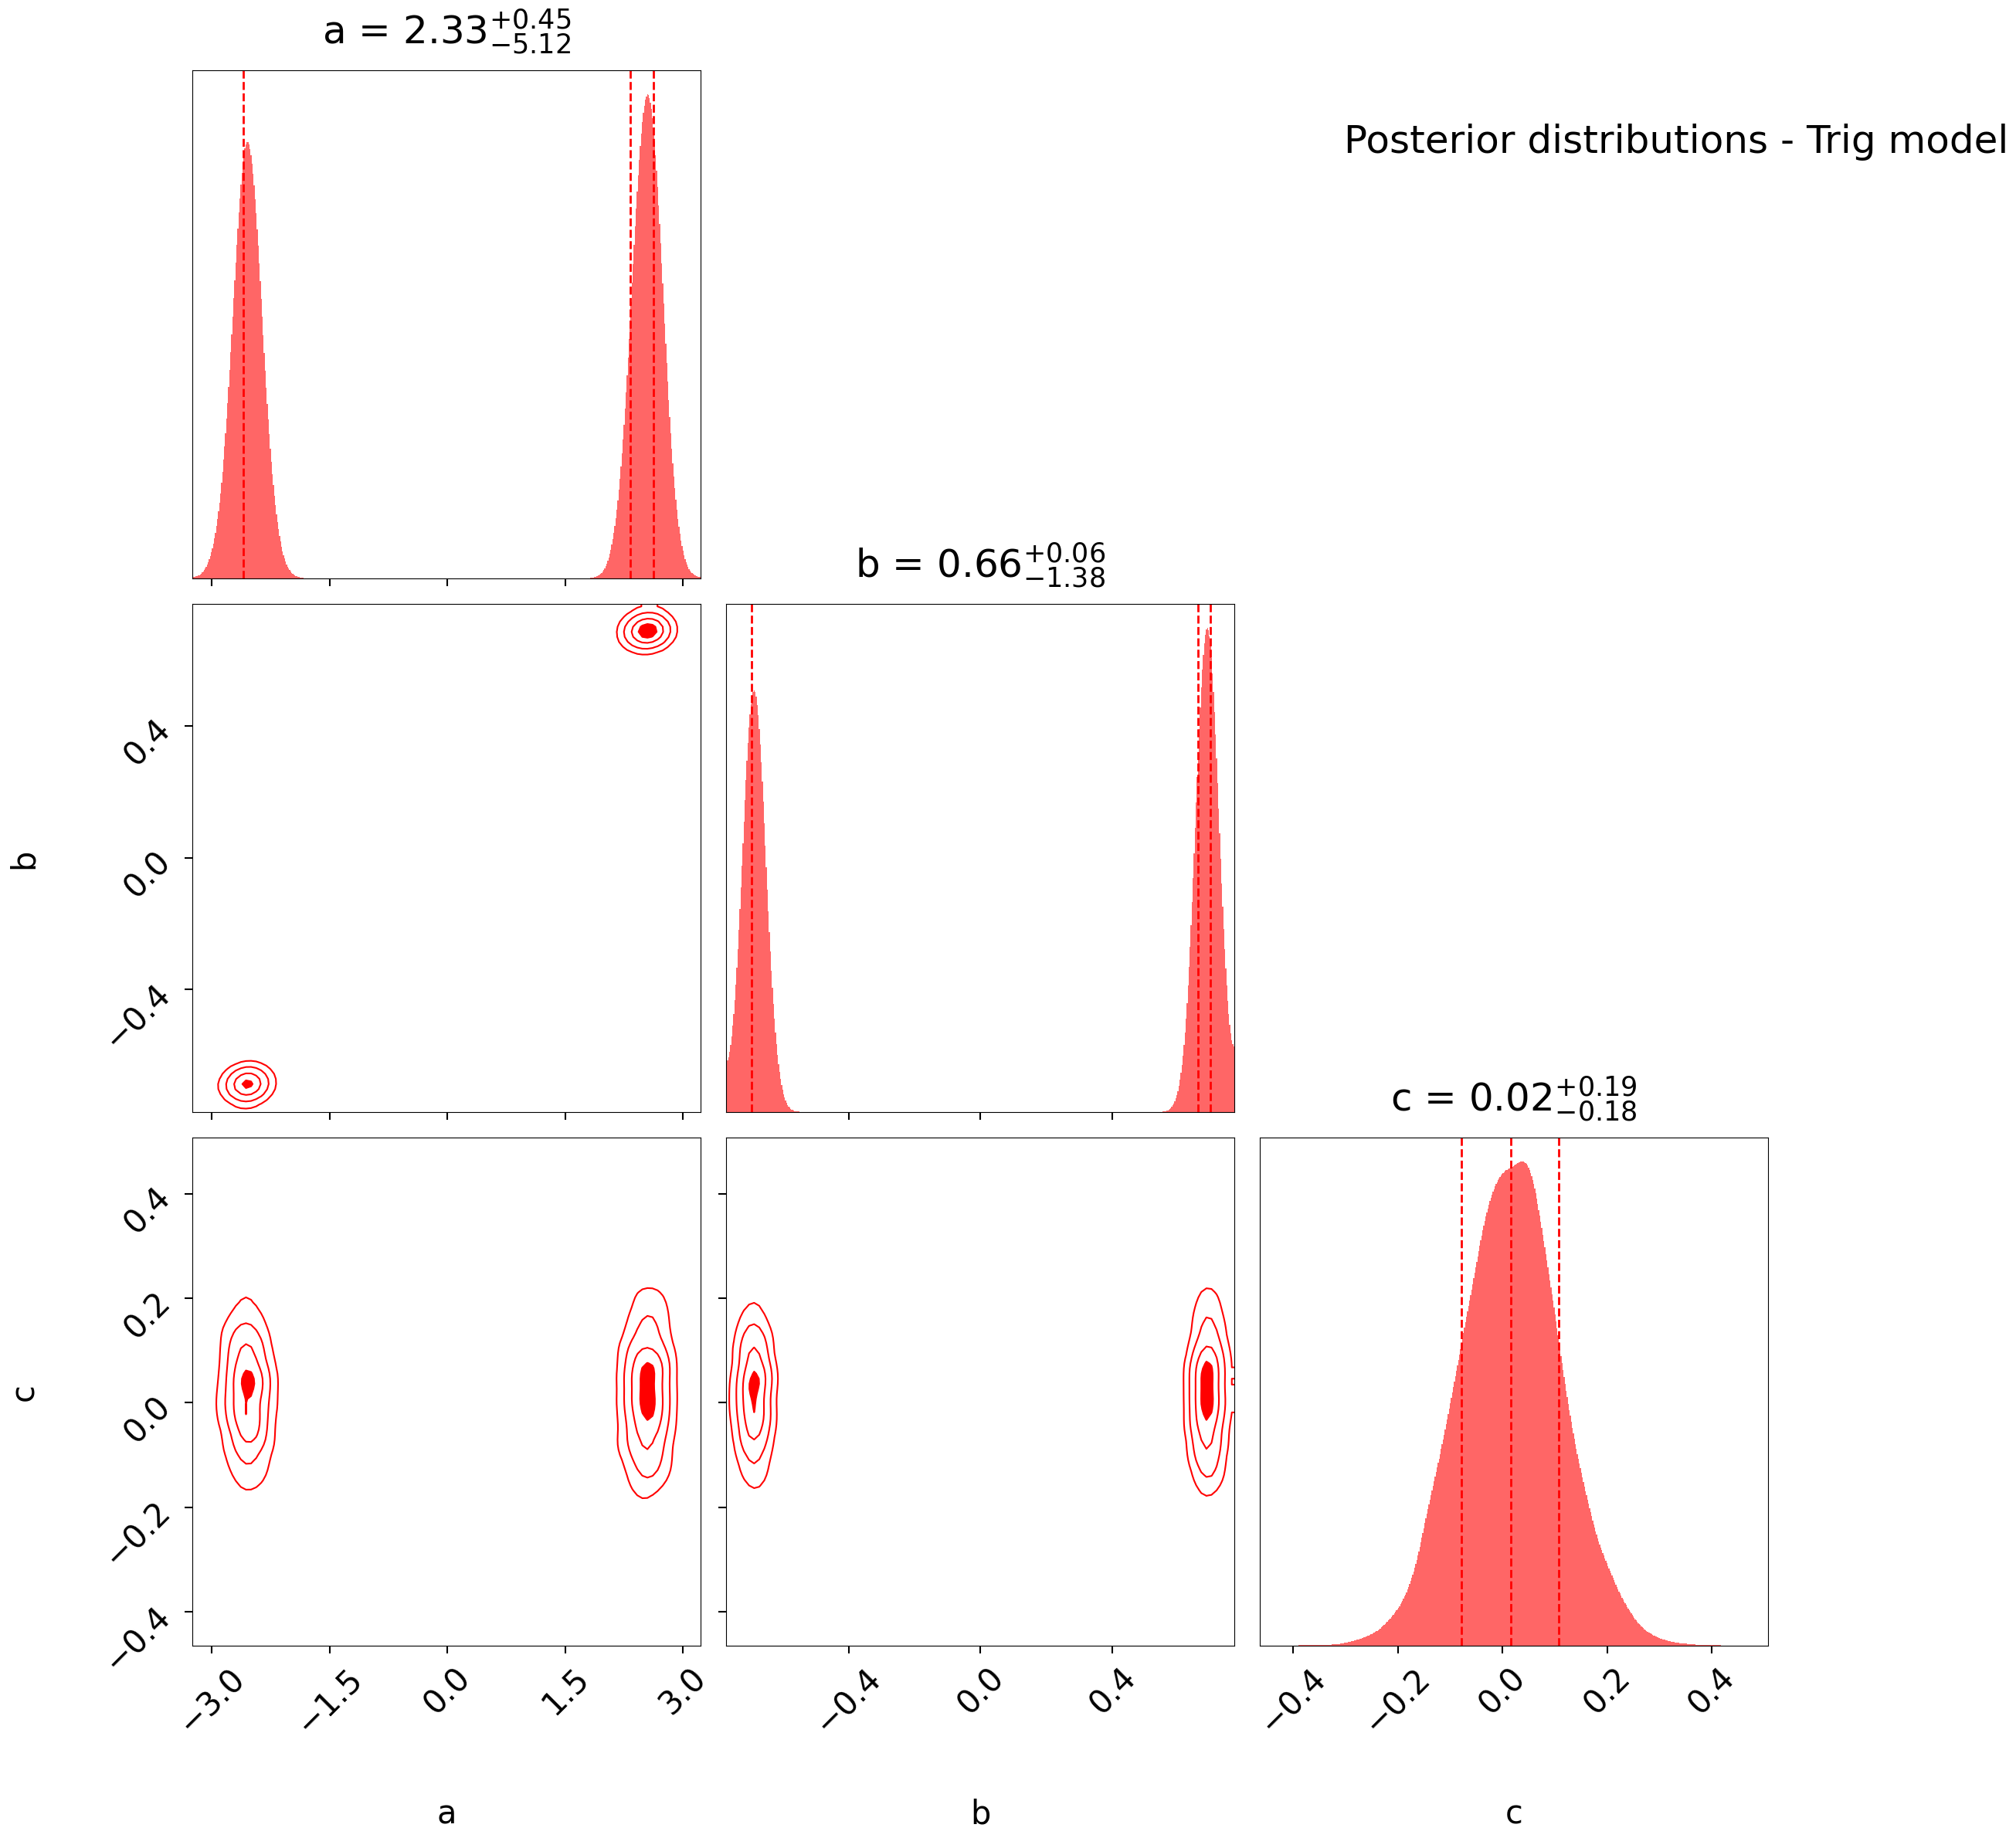

In [ ]:
# And the corner plots
fig_poly3, axes_poly3 = dyplot.cornerplot(results_poly3,
                                   color='blue',
                                   show_titles=True,
                                   title_fmt='.2f',
                                   title_kwargs={'y': 1.04},
                                   labels=parameters_poly3,
                                   quantiles=[0.16, 0.5, 0.84],
                                   fig=plt.subplots(n_params_poly3, n_params_poly3,
                                                    figsize=(25, 25)),)
plt.suptitle('Posterior distributions - Poly3 model', y=0.92, x=0.90)
plt.show()

fig_poly5, axes_poly5 = dyplot.cornerplot(results_poly5,
                                   color='green',
                                   show_titles=True,
                                   title_fmt='.2f',
                                   title_kwargs={'y': 1.04},
                                   labels=parameters_poly5,
                                   quantiles=[0.16, 0.5, 0.84],
                                   fig=plt.subplots(n_params_poly5, n_params_poly5,
                                                    figsize=(25, 25)),)
plt.suptitle('Posterior distributions - Poly5 model', y=0.92, x=0.90)
plt.show()

fig_trig, axes_trig = dyplot.cornerplot(results_trig,
                                   color='red',
                                   show_titles=True,
                                   title_fmt='.2f',
                                   title_kwargs={'y': 1.04},
                                   labels=parameters_trig,
                                   quantiles=[0.16, 0.5, 0.84],
                                   fig=plt.subplots(n_params_trig, n_params_trig,
                                                    figsize=(25, 25)),)
plt.suptitle('Posterior distributions - Trig model', y=0.92, x=0.90)
plt.show()

Finally, let's see how each model fits the data.

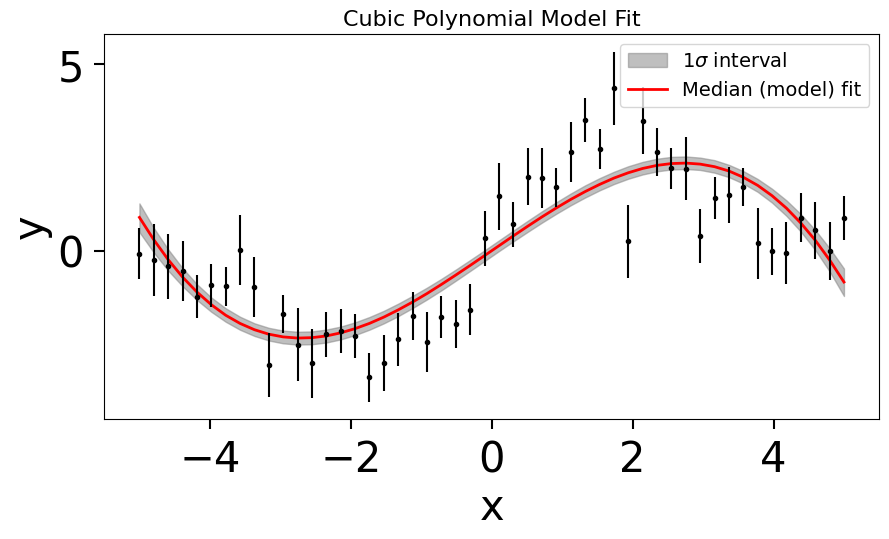

In [ ]:
# Poly3 model
poly3_equal_samples = results_poly3.samples_equal()
poly3_models = np.empty((len(poly3_equal_samples), len(x)))

for i in range(len(poly3_equal_samples)):
    poly3_models[i] = model_poly3(*poly3_equal_samples[i], x)

plt.figure(figsize=(10, 5))

# Compute the 16th, 50th, and 84th percentiles at each x value
low, mid, high = np.percentile(poly3_models, [16, 50, 84], axis=0)

plt.fill_between(x, low, high, color="gray", alpha=0.5, label="1$\sigma$ interval")
plt.plot(x, mid, color="red", label="Median (model) fit", lw=2)

plt.errorbar(x, yobs, yerr=yerr, fmt=".k", capsize=0)
plt.legend(fontsize=14)
plt.title("Cubic Polynomial Model Fit", fontsize=16)

plt.xlabel("x")
plt.ylabel("y");


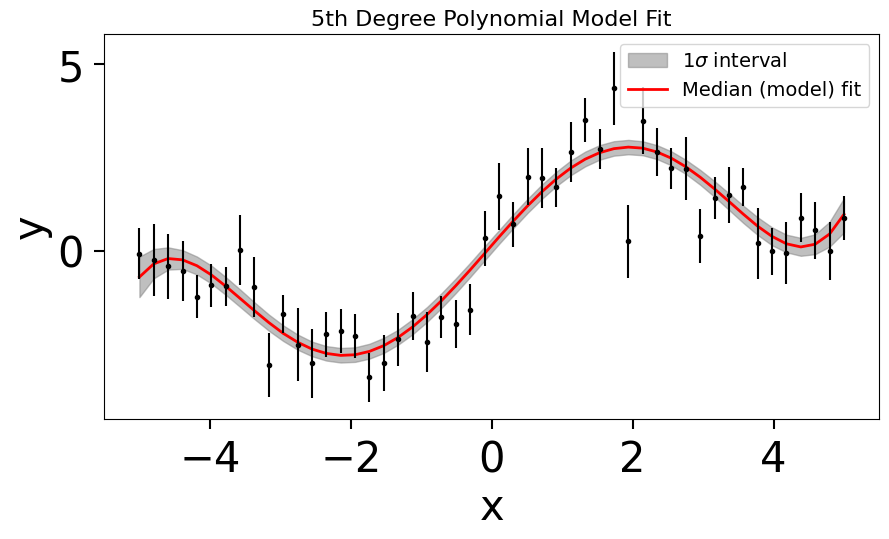

In [ ]:
# poly5 model
poly5_equal_samples = results_poly5.samples_equal()
poly5_models = np.empty((len(poly5_equal_samples), len(x)))

for i in range(len(poly5_equal_samples)):
    poly5_models[i] = model_poly5(*poly5_equal_samples[i], x)

plt.figure(figsize=(10, 5))

# Compute the 16th, 50th, and 84th percentiles at each x value
low, mid, high = np.percentile(poly5_models, [16, 50, 84], axis=0)

plt.fill_between(x, low, high, color="gray", alpha=0.5, label="1$\sigma$ interval")
plt.plot(x, mid, color="red", label="Median (model) fit", lw=2)

plt.errorbar(x, yobs, yerr=yerr, fmt=".k", capsize=0)
plt.legend(fontsize=14)
plt.title("5th Degree Polynomial Model Fit", fontsize=16)

plt.xlabel("x")
plt.ylabel("y");


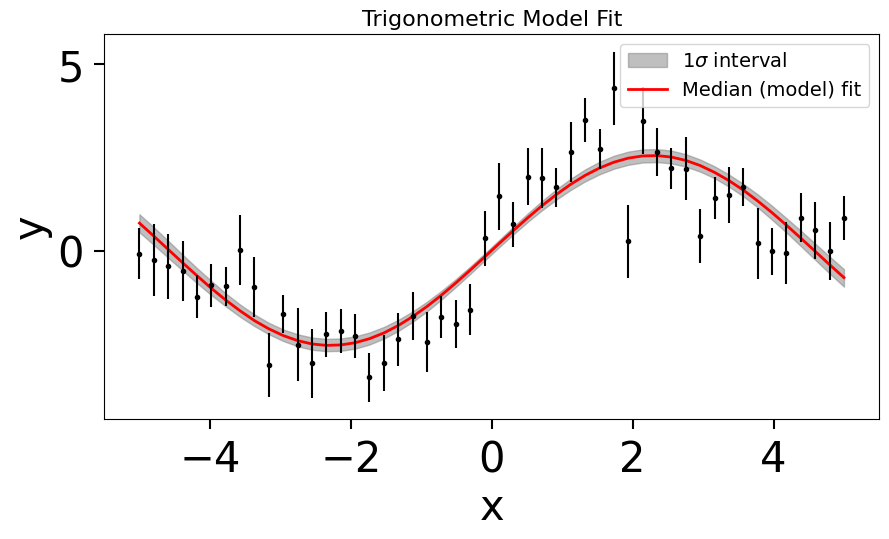

In [ ]:
# Trig model
trig_equal_samples = results_trig.samples_equal()
trig_models = np.empty((len(trig_equal_samples), len(x)))

for i in range(len(trig_equal_samples)):
    trig_models[i] = model_trig(*trig_equal_samples[i], x)

plt.figure(figsize=(10, 5))

# Compute the 16th, 50th, and 84th percentiles at each x value
low, mid, high = np.percentile(trig_models, [16, 50, 84], axis=0)

plt.fill_between(x, low, high, color="gray", alpha=0.5, label="1$\sigma$ interval")
plt.plot(x, mid, color="red", label="Median (model) fit", lw=2)

plt.errorbar(x, yobs, yerr=yerr, fmt=".k", capsize=0)
plt.legend(fontsize=14)
plt.title("Trigonometric Model Fit", fontsize=16)

plt.xlabel("x")
plt.ylabel("y");


Let's have a look at all models together

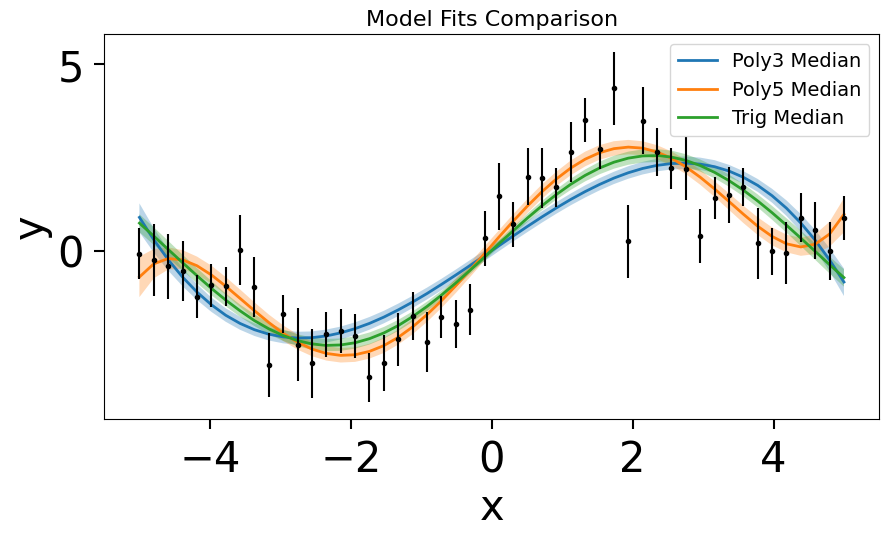

In [ ]:
from matplotlib.lines import Line2D

plt.figure(figsize=(10, 5))

for model in [poly3_models, poly5_models, trig_models]:
    low, mid, high = np.percentile(model, [16, 50, 84], axis=0)
    plt.fill_between(x, low, high, alpha=0.3)
    plt.plot(x, mid, lw=2)
plt.errorbar(x, yobs, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Model Fits Comparison", fontsize=16)
# Add legend with correct colors for each model

legend_elements = [
    Line2D([0], [0], color='C0', lw=2, label='Poly3 Median'),
    Line2D([0], [0], color='C1', lw=2, label='Poly5 Median'),
    Line2D([0], [0], color='C2', lw=2, label='Trig Median')
]
plt.legend(handles=legend_elements, fontsize=14)
plt.show()

Finally, let's compare the evidences of the three models. The one with the highest evidence is the most probable model given the data.

In [ ]:
poly3_evidence = results_poly3.logz[-1]        # log-evidence
poly3_evid_err = results_poly3.logzerr[-1]     # log-evidence error

poly5_evidence = results_poly5.logz[-1]        # log-evidence
poly5_evid_err = results_poly5.logzerr[-1]     # log-evidence error

trig_evidence = results_trig.logz[-1]          # log-evidence
trig_evid_err = results_trig.logzerr[-1]       # log-evidence error


print(f"Poly3 Model: logZ = {poly3_evidence:.2f} ± {poly3_evid_err:.2f}")
print(f"Poly5 Model: logZ = {poly5_evidence:.2f} ± {poly5_evid_err:.2f}")
print(f"Trig Model: logZ = {trig_evidence:.2f} ± {trig_evid_err:.2f}")

Poly3 Model: logZ = -103.97 ± 0.26
Poly5 Model: logZ = -93.03 ± 0.33
Trig Model: logZ = -78.06 ± 0.20


It means that the trig model is more supported by the data compared to the poly3 and poly5 models.
But how much more? We can use the Bayes factor to quantify this. The Bayes factor between two models is given by the ratio of their evidences. In terms of log-evidences, this is simply the difference:

In [ ]:

bayes_factor_trig_poly3 = np.exp(trig_evidence - poly3_evidence)
bayes_factor_trig_poly5 = np.exp(trig_evidence - poly5_evidence)

print(f"The trig model is {bayes_factor_trig_poly3:.2f} times more likely than the poly3 model.")
print(f"The trig model is {bayes_factor_trig_poly5:.2f} times more likely than the poly5 model.")

The trig model is 178454216738.63 times more likely than the poly3 model.
The trig model is 3179048.46 times more likely than the poly5 model.


It is also good to have a look at some tables, like the Jeffreys scale for interpreting Bayes factors.
    
### Jeffreys' Scale

| $\ln B_{10}$ Value | $B_{10}$ Value | Strength of Evidence for $M_1$ over $M_0$ |
|:------------------:|:--------------:|:---------------------------------------:|
| < 0                | < 1            | Negative (favors $M_0$)                 |
| 0 to 1.15          | 1 to 3.2       | Barely worth mentioning                 |
| 1.15 to 2.3        | 3.2 to 10      | Substantial                             |
| 2.3 to 4.6         | 10 to 100      | Strong                                  |
| > 4.6              | > 100          | Decisive                                |

In [ ]:
print("Bayes factors:")
print(f"Trig vs Poly3: {np.log(bayes_factor_trig_poly3):.2f}")
print(f"Trig vs Poly5: {np.log(bayes_factor_trig_poly5):.2f}")

Bayes factors:
Trig vs Poly3: 25.91
Trig vs Poly5: 14.97


According to the Jeffreys scale, the trig model is strongly favored over both polynomial models.

# Do not overinterpret the results! ##

`"Remember that all models are wrong; the practical question is how wrong do they have to be to not be useful." (George Box)`

When analysing Bayesian evidence, there are a few important things to consider.

- The Influence of Priors

The evidence you get is subject to noise and is influenced by your priors. It's always a good idea to experiment with your priors to see how they impact the final result.

- The Problem of the "True" Model

So far, we've assumed that all models are equally likely, but that isn't always true. Sometimes, you need strong physical reasons to prefer one model over another. However, justifying that preference can be tricky.

- The Limits of the Bayes Factor

Finally, the Bayes Factor will only tell you which of your models is the most probable one based on your data and assumptions. But keep in mind that there's a good chance that none of the models you're comparing is the "correct" one.

----